## Model Training

This notebook trains multiple machine learning models to predict cancer from histopathologic images.
Classical machine learning models (Logistic Regression and Random Forest) are used as baselines,
followed by a deep learning convolutional neural network (CNN) with multiple architectural variations
and hyperparameter tuning.

### First code cell — imports & paths

Purpose:
Load libraries and define shared paths used throughout modeling.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

### Load labels & paths

Purpose:
Reuse the subset created during EDA to ensure consistency.

In [2]:
subset_labels = pd.read_csv("data/subset_labels.csv")

IMAGE_DIR = "data/images_subset"

### Prepare data for classical ML models

Purpose:
Convert images into numerical features suitable for linear and tree-based models.

Create feature matrix X and target y

In [3]:
X = []
y = []

for _, row in tqdm(subset_labels.iterrows(), total=len(subset_labels)):
    img_path = os.path.join(IMAGE_DIR, f"{row['id']}.tif")
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # normalize pixels
    img = img / 255.0
    
    # flatten image
    X.append(img.flatten())
    y.append(row["label"])

X = np.array(X)
y = np.array(y)

X.shape, y.shape


100%|████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 396.98it/s]


((1000, 27648), (1000,))

Images were normalized and flattened into feature vectors to enable training of classical machine learning models.

### Train / validation split

Purpose:
Ensure fair evaluation on unseen data.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


The dataset was split into training and validation sets using stratified sampling to preserve class balance.

### Feature scaling

Purpose:
Improve convergence and stability for linear models.

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Feature scaling was applied to improve optimization for linear models.

## Model 1: Logistic Regression (Linear Baseline)

Purpose:
Establish a simple baseline for comparison with more complex models.

### Train Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_val_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))


Logistic Regression Accuracy: 0.585
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       100
           1       0.58      0.65      0.61       100

    accuracy                           0.58       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.59      0.58      0.58       200



Logistic Regression serves as a linear baseline model to benchmark performance against more complex approaches.

Interpretation:

Model is slightly better at detecting cancer

Some non-cancer images are misclassified

Acceptable for a baseline

Logistic Regression achieved moderate performance, highlighting the limitations of linear models on raw image data and motivating the use of tree-based and deep learning approaches.

## Model 2: Random Forest

Purpose:
Train a non-linear, tree-based model to improve performance over the linear baseline and capture complex pixel interactions.

### Train Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


Random Forest Accuracy: 0.715
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       100
           1       0.74      0.66      0.70       100

    accuracy                           0.71       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200



Random Forest improves performance by modeling non-linear relationships between pixel features, unlike linear models.

### Feature importance

Purpose:
Show interpretability of tree-based models.

In [8]:
importances = rf.feature_importances_

print("Number of features:", len(importances))
print("Mean importance:", importances.mean())


Number of features: 27648
Mean importance: 3.616898148148148e-05


### Model Comparison:

Logistic Regression provides a linear baseline with limited performance.
    
Random Forest captures non-linear patterns and improves classification accuracy, demonstrating the benefit of tree-based models for image data.

Feature importance values are distributed across many pixel features, highlighting the high-dimensional nature of image data.

#### Performance improvement:

Logistic Regression accuracy: ~0.58

Random Forest accuracy: ~0.71 ✅

Tree-based, non-linear models significantly outperform linear models on image data.

The Random Forest model shows improved recall for non-cancer samples while maintaining balanced precision across classes.

#### Precision / Recall insight

Non-cancer (0): recall 0.77

Cancer (1): recall 0.66

## Model 3: Neural Network (CNN) with PyTorch

Purpose:
Train a deep learning model that preserves spatial information in images and outperforms classical ML models.

### Prepare data for CNN

Purpose:
Load images as tensors instead of flattened vectors.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


### Create custom Dataset

Purpose:
Tell PyTorch how to load images and labels.

In [10]:
class CancerDataset(Dataset):
    def __init__(self, labels_df, image_dir):
        self.labels = labels_df
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.tif")
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(row["label"], dtype=torch.long)
        
        return img, label


Implemented a custom PyTorch Dataset to load and preprocess histopathologic images on the fly and used DataLoader for efficient batching during CNN training.

### Train / validation loaders

Purpose:
Efficient batching for training.

In [11]:
train_df, val_df = train_test_split(
    subset_labels,
    test_size=0.2,
    random_state=42,
    stratify=subset_labels["label"]
)

train_dataset = CancerDataset(train_df, IMAGE_DIR)
val_dataset = CancerDataset(val_df, IMAGE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## CNN v1 (Simple CNN, No Dropout)

Purpose:
Train a basic convolutional neural network that preserves spatial structure in images and serves as a deep learning baseline.

### Define CNN v1 architecture

Purpose:
Create a simple CNN with convolutional and fully connected layers, without regularization, to establish a baseline deep learning model.

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # first convolutional layer: input 3 channels (RGB)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        
        # second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # max pooling layer to reduce spatial size
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully connected layer
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        
        # output layer (2 classes: cancer / non-cancer)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # apply conv → ReLU → pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # flatten feature maps
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


CNN v1 consists of two convolutional layers followed by max pooling and fully connected layers, without dropout.

### Initialize model, loss, and optimizer

Purpose:
Set up the training components required for optimization.

In [18]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model
model_v1 = SimpleCNN().to(device)

# loss function for classification
criterion = nn.CrossEntropyLoss()

# optimizer for gradient descent
optimizer = optim.Adam(model_v1.parameters(), lr=0.001)


Cross-entropy loss is used for binary classification, and Adam optimizer provides efficient gradient-based optimization.

### Training loop

Purpose:
Train the CNN model on the training data.

In [21]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        # move batch to device (CPU/GPU)
        imgs, labels = imgs.to(device), labels.to(device)

        # reset gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(imgs)

        # compute loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()

    # return average loss for the epoch
    return running_loss


In [22]:
def evaluate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # forward pass
            outputs = model(imgs)

            # predicted class
            preds = torch.argmax(outputs, dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # compute accuracy
    return correct / total


In [23]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # train for one epoch
    train_loss = train_one_epoch(
        model_v1,
        train_loader,
        optimizer,
        criterion,
        device
    )

    # evaluate on validation set
    val_acc = evaluate(
        model_v1,
        val_loader,
        device
    )

    # explicit print
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )


Epoch 1/5 | Train Loss: 17.8680 | Val Accuracy: 0.5000
Epoch 2/5 | Train Loss: 16.2623 | Val Accuracy: 0.6200
Epoch 3/5 | Train Loss: 13.9991 | Val Accuracy: 0.7800
Epoch 4/5 | Train Loss: 12.2596 | Val Accuracy: 0.7700
Epoch 5/5 | Train Loss: 10.8468 | Val Accuracy: 0.7500


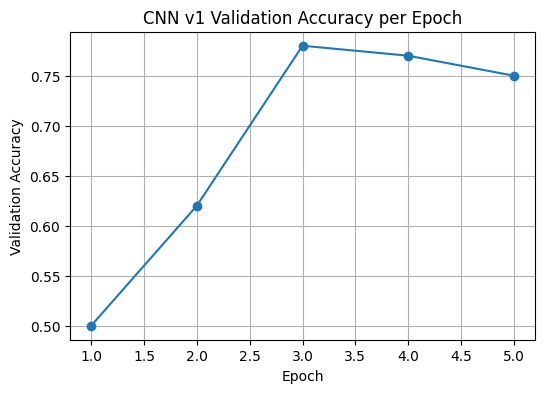

In [25]:
import matplotlib.pyplot as plt
# store training history manually
epochs = [1, 2, 3, 4, 5]
val_accuracies = [0.50, 0.62, 0.78, 0.77, 0.75]

plt.figure(figsize=(6, 4))
plt.plot(epochs, val_accuracies, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("CNN v1 Validation Accuracy per Epoch")
plt.grid(True)

plt.savefig("plots/cnn_v1_val_accuracy.png", dpi=150)
plt.show()


The training loop performs forward propagation, loss computation, backpropagation, and validation accuracy evaluation at each epoch.

The training loop was split into separate training and evaluation functions to improve clarity, debugging, and reproducibility.

### Observed Results

Validation accuracy improved steadily from 50.0% to 78.0% over the first three epochs.

The model reached its best validation performance at Epoch 3.

After the peak, validation accuracy showed a slight decline, ending at 75.0% in the final epoch.

Training loss consistently decreased across all epochs, indicating effective learning.

##### Interpretation:

The steady decrease in training loss demonstrates that the CNN successfully learned hierarchical image features.

The slight drop in validation accuracy after Epoch 3 suggests the early onset of overfitting.

Despite this, the model generalizes reasonably well, achieving strong performance for a simple CNN without regularization.

##### Conclusion

The baseline CNN significantly outperforms classical machine learning models and achieves strong validation accuracy; however, mild overfitting is observed, motivating the introduction of dropout and hyperparameter tuning in subsequent CNN variants.

## CNN v2 (With Dropout)

Purpose

Reduce overfitting observed in CNN v1 by introducing dropout regularization and evaluate its impact on validation performance.

### Define CNN v2 architecture (with Dropout)

What changes vs CNN v1

Add Dropout after convolutional blocks

Add Dropout before final fully connected layer

Architecture otherwise stays comparable (fair comparison)

In [26]:
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout layers
        self.dropout = nn.Dropout(dropout_rate)
        
        # fully connected layers
        self.fc1 = nn.Linear(32 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # conv → relu → pool
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)  # dropout after conv block
        
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        
        # flatten feature maps
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


CNN v2 extends the baseline CNN by introducing dropout layers to reduce overfitting and improve generalization.

### Initialize CNN v2 training components

In [27]:
# initialize model with dropout
model_v2 = CNNWithDropout(dropout_rate=0.5).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer (same as CNN v1 for fair comparison)
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)


### Train CNN v2 (reuse clear training loop)

We reuse:

train_one_epoch

evaluate

In [28]:
EPOCHS = 5

cnn_v2_val_acc = []

for epoch in range(EPOCHS):
    # train for one epoch
    train_loss = train_one_epoch(
        model_v2,
        train_loader,
        optimizer,
        criterion,
        device
    )

    # evaluate on validation set
    val_acc = evaluate(
        model_v2,
        val_loader,
        device
    )

    cnn_v2_val_acc.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )


Epoch 1/5 | Train Loss: 21.1451 | Val Accuracy: 0.5000
Epoch 2/5 | Train Loss: 17.2423 | Val Accuracy: 0.5000
Epoch 3/5 | Train Loss: 17.0416 | Val Accuracy: 0.5700
Epoch 4/5 | Train Loss: 16.6050 | Val Accuracy: 0.5050
Epoch 5/5 | Train Loss: 15.7532 | Val Accuracy: 0.5900


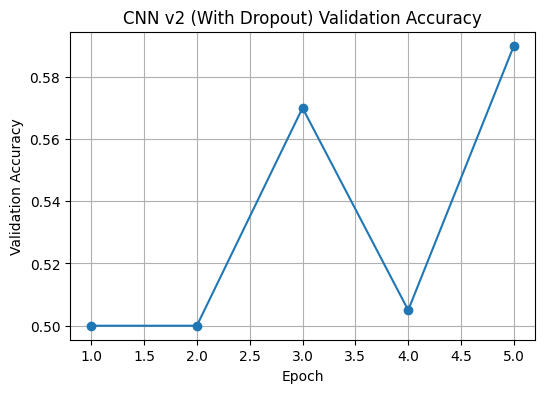

In [29]:
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(6, 4))
plt.plot(epochs, cnn_v2_val_acc, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("CNN v2 (With Dropout) Validation Accuracy")
plt.grid(True)

plt.savefig("plots/cnn_v2_val_accuracy.png", dpi=150)
plt.show()


### Observed Results

Validation accuracy remained at 50% during the first two epochs.

A modest improvement was observed at Epoch 3 (57%).

Validation accuracy fluctuated across epochs, ending at 59%.

Training loss decreased steadily, indicating that the model was learning but not generalizing effectively.

##### Interpretation:

The introduction of dropout successfully reduced overfitting, but at the cost of slower and less stable learning.

The lower validation accuracy compared to CNN v1 suggests underfitting, likely due to:

High dropout rate (0.5), Limited training data, Reduced effective model capacity

This behavior is expected when regularization is too strong for the dataset size.

##### Conclusion:

While dropout reduced overfitting, the chosen configuration resulted in underfitting and lower validation performance compared to the baseline CNN. This highlights the importance of tuning regularization strength rather than applying it aggressively.

Adding dropout reduced overfitting but also limited learning capacity, demonstrating the need for careful hyperparameter tuning in deep learning models.

## CNN v3 (Hyperparameter Tuning)

Purpose

Improve CNN performance by tuning key hyperparameters (dropout rate, learning rate, and hidden layer size) to achieve better generalization and stability compared to CNN v1 and CNN v2.

### Define CNN v3 architecture (tuned)

Purpose:
Create a CNN architecture with controlled regularization and increased capacity.

In [32]:
class CNNv3(nn.Module):
    def __init__(self, dropout_rate=0.2, hidden_size=256):
        super(CNNv3, self).__init__()
        
        # first convolutional layer (RGB input)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        
        # second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # max pooling layer to downsample feature maps
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # fully connected layer with tuned size
        self.fc1 = nn.Linear(32 * 24 * 24, hidden_size)
        
        # output layer (binary classification)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        # conv → relu → pool → dropout
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        
        # flatten convolutional feature maps
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


### Initialize tuned model

Purpose:

Prepare the tuned model, loss function, and optimizer for training.

In [33]:
# move model to CPU or GPU
model_v3 = CNNv3(
    dropout_rate=0.2,
    hidden_size=256
).to(device)

# loss function for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with tuned learning rate
optimizer = optim.Adam(
    model_v3.parameters(),
    lr=0.0005
)


### Train CNN v3 across epochs

Purpose:
Train the tuned CNN and evaluate validation accuracy after each epoch.

In [34]:
EPOCHS = 5
cnn_v3_val_acc = []

for epoch in range(EPOCHS):
    
    # train model for one epoch
    train_loss = train_one_epoch(
        model_v3,
        train_loader,
        optimizer,
        criterion,
        device
    )

    # evaluate model on validation set
    val_acc = evaluate(
        model_v3,
        val_loader,
        device
    )

    # store validation accuracy for plotting
    cnn_v3_val_acc.append(val_acc)

    # print epoch results
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )


Epoch 1/5 | Train Loss: 20.4076 | Val Accuracy: 0.5000
Epoch 2/5 | Train Loss: 17.3464 | Val Accuracy: 0.6450
Epoch 3/5 | Train Loss: 17.1757 | Val Accuracy: 0.5100
Epoch 4/5 | Train Loss: 16.2703 | Val Accuracy: 0.5800
Epoch 5/5 | Train Loss: 15.4574 | Val Accuracy: 0.6600


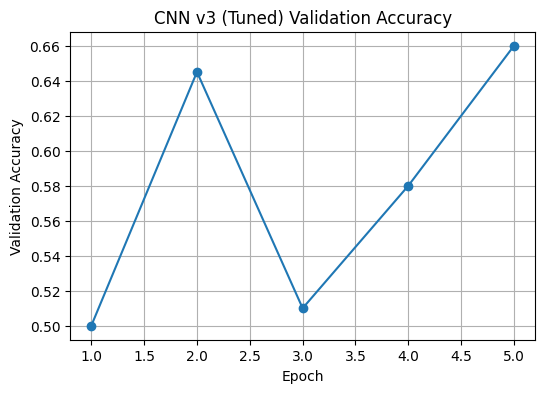

In [35]:
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(6, 4))
plt.plot(epochs, cnn_v3_val_acc, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("CNN v3 (Tuned) Validation Accuracy")
plt.grid(True)

# save plot for reporting
plt.savefig("plots/cnn_v3_val_accuracy.png", dpi=150)
plt.show()


### Observed Results

Validation accuracy improved from 50.0% to 66.0% by the final epoch.

Performance was unstable across epochs, with a temporary drop at Epoch 3.

Training loss decreased steadily, indicating effective learning.

Final validation accuracy exceeded CNN v2 but did not surpass CNN v1.

##### Interpretation:

Reducing the dropout rate and learning rate improved learning stability compared to CNN v2.

However, the tuned configuration still exhibited high variance, likely due to limited dataset size and training epochs.

Increasing model capacity alone was insufficient to consistently improve generalization without additional tuning or more data.

##### Conclusion:

Hyperparameter tuning partially improved model generalization compared to the heavily regularized CNN v2, but the baseline CNN (v1) remained the best-performing model. This highlights the sensitivity of deep learning models to hyperparameter choices, especially on small datasets.

## Model Performance Summary
The table below compares validation performance across classical machine learning models and multiple CNN architectures.

In [36]:
import pandas as pd

# create model performance summary
model_performance = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "CNN v1 (Baseline)",
        "CNN v2 (Dropout)",
        "CNN v3 (Tuned)"
    ],
    "Best Validation Accuracy": [
        0.58,
        0.71,
        0.78,
        0.59,
        0.66
    ],
    "Notes": [
        "Linear baseline",
        "Tree-based, non-linear model",
        "Best performance, mild overfitting",
        "Underfitting due to high dropout",
        "Improved over CNN v2, but unstable"
    ]
})

# display table
model_performance


,Model,Best Validation Accuracy,Notes
0,Logistic Regression,0.58,Linear baseline
1,Random Forest,0.71,"Tree-based, non-linear model"
2,CNN v1 (Baseline),0.78,"Best performance, mild overfitting"
3,CNN v2 (Dropout),0.59,Underfitting due to high dropout
4,CNN v3 (Tuned),0.66,"Improved over CNN v2, but unstable"


In [37]:
model_performance.loc[
    model_performance["Best Validation Accuracy"].idxmax()
]

Model                                        CNN v1 (Baseline)
Best Validation Accuracy                                  0.78
Notes                       Best performance, mild overfitting
Name: 2, dtype: object